In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP, plot_N, TDR_axes, out_axes, plot_FP_jitter, make_FP_axs, comp_eig_decomp
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names, gen_X_from_model_dir_epoch
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [2]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v3_figs','interp_stim')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [4]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'randgauss'#''diag'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7
seed = '1'
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/lr'
m = os.path.join(p,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

In [5]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('delaygo', hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo

In [6]:
def get_interp_filename(trial1,trial2,epoch_list,t_set):
    n_stim_per_ring = int(np.shape(trial1.y)[2]-1)
    stim_size = int(2*n_stim_per_ring+1)

    rule1 = rules_dict['all'][np.argmax(trial1.x[0,0,stim_size:])]
    rule2 = rules_dict['all'][np.argmax(trial2.x[0,0,stim_size:])]
    ind_stim_loc1  = 180*trial1.y_loc[-1,t_set[0]]/np.pi
    ind_stim_loc2  = 180*trial2.y_loc[-1,t_set[1]]/np.pi
    filename = rule1+'_'+rule2+'_'+'_'.join(epoch_list)+'_x'+str(round(ind_stim_loc1,2))+'_x'+str(round(ind_stim_loc2,2))

    return filename

In [6]:
# def get_single_task_fp_filename(trial, epoch,t):
#     ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
#     nonzero_stim = trial.stim_locs[t,:]<100
#     stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
#     filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

#     return filename

In [7]:
# def plot_h_interp_input(ax, h0, x_t, D_use, params, hparams, lw = 4, al = .6, 
#                         linestyle = '-',c = 'k', dim3 = 'True'):
    
#     alpha = hparams['dt']/hparams['tau']
#     h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
    
#     if sum(np.diff(np.sum(x_t,axis = 1)))>0:
#         e_start = np.where(np.diff(np.sum(x_t,axis = 1))>0)[0][0]+1
#     else:
#         e_start = 0
            
#     jitter = np.dot(h_t[e_start:,:],D_use)
    
#     if dim3 == 'True':
#         ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = c,linewidth = lw,alpha = al)
#     else:
#         ax.plot(jitter[:,0],jitter[:,1],'-',c = c,linewidth = lw,alpha = al)
#         ax.plot(jitter[:,0],jitter[:,1],'-',c = 'k',linewidth = .3,alpha = 1)
#         ax.plot(jitter[-1,0],jitter[-1,1],'x',c = 'k',markeredgewidth = 2,alpha = 1)
        
#     return h_t

In [8]:
# def interp_h_tasks(ri_set,trial_num,epoch_list,D_use = [],n_trials = 8,n_steps = 25,n_interp = 30,linestyle = ['-',':']):
#     fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
#     ax = fig.add_subplot(111)
#     cmap_grad = plt.get_cmap('plasma')
#     cmap_stim = plt.get_cmap('hsv')

#     if len(D_use)==0:
#         ri_axs = 0
#         axs = 'pca_h'
#         epoch = epoch_list[0]
#         rule = rules_dict['all'][ri_set[ri_axs]]
#         trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
#         save_dir = os.path.join(m,'tf_fixed_pts_all_init',rule)
#         f = get_single_task_fp_filename(trial,epoch,trial_num[ri_axs])
#         filename = os.path.join(save_dir,f+'.npz')
#         D_use = make_FP_axs(filename, m, rules_dict['all'][ri_set[0]], epoch, axs = axs, clust = 'False')

#     epoch_name, rule_name1, _, _ = take_names(epoch,rules_dict['all'][ri_set[0]])
#     _, rule_name2, _, _ = take_names(epoch,rules_dict['all'][ri_set[1]])
#     axes_label1 = axs+' 1'
#     axes_label2 = axs+' 2'

#     rule1 = rules_dict['all'][ri_set[0]]
#     trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
#     trial2 = same_stim_trial(trial1, ri_set[1]) 
#     trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

#     trial_set = [trial1,trial2]

#     T_inds1 = get_T_inds(trial1,epoch_list[0])
#     inputs_1 = trial1.x[T_inds1[1],trial_num[0],:]

#     T_inds2 = get_T_inds(trial2,epoch_list[1])
#     inputs_2 = trial2.x[T_inds2[1],trial_num[1],:]

#     del_inputs = inputs_2 - inputs_1

#     for ri in [1,0]:
#         rule = rules_dict['all'][ri_set[ri]]
#         trial = trial_set[ri]

#         _,x = gen_X_from_model_dir(m,trial)
#         T_inds = get_T_inds(trial,epoch)
#         h_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

#         big_stim_trials = np.where(trial.stim_strength[:,0]>.99)[0]

#         for ti_ind in range(0,len(big_stim_trials),int(len(big_stim_trials)/n_trials)):
#             ti = big_stim_trials[ti_ind]

#             trial_label = str(round(np.min(trial.stim_locs[ti,:])/np.pi,1))+ ' pi'

#             h0 = h_epoch[ti,0,:]
#             x_t = np.matlib.repmat(trial.x[T_inds[0],ti,:],n_steps,1)
#             h_t = vanilla_run_with_h0(params, x_t, h0, hparams)

#             jitter = np.dot(h_t,D_use)
#             plt.plot(jitter[-1,0],jitter[-1,1],'^',c = cmap_stim(ti/np.shape(x)[1]),
#                      linewidth = 8,label = trial_label)
#             plt.plot(jitter[:,0],jitter[:,1],c = cmap_stim(ti/np.shape(x)[1]),
#                      linewidth = 8,alpha = .5, linestyle = linestyle[ri])
#     #         plt.plot(jitter[:,0],jitter[:,1],'-',c = c_discrete[ri],linewidth = 3,alpha = .5)

#     for step_i in range(n_interp):

#         step_inputs = inputs_1[np.newaxis,:]+del_inputs[np.newaxis,:]*(step_i/n_interp)
#         x_t = np.matlib.repmat(step_inputs,n_steps,1)
#         h0 = h_epoch[trial_num[ri],0,:]

#         plot_h_interp_input(ax, h0, x_t, D_use, params, hparams, lw = 1, al = .3, 
#                             linestyle = '-',c = cmap_grad(step_i/n_interp), dim3 = 'False')

#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.set_yticks([])
#     ax.set_xticks([])
#     plt.xlabel('')
#     plt.ylabel('')
#     plt.title('')

#     tasks_str = '_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]])
#     step_file='interp_h'
#     if not os.path.exists(os.path.join(figpath,step_file,tasks_str)):
#         os.makedirs(os.path.join(figpath,step_file,tasks_str))

#     figname = axes_label1+'_'+axes_label2+'_'+epoch+'_'+tasks_str
#     plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.pdf'))
#     plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.png'))
#     return ax

In [9]:
# from mpl_toolkits.mplot3d import Axes3D

# def interp_h_tasks_wfps_3d(ri_set,trial_num,epoch_list,D_use = [],n_trials = 8,n_steps = 25,n_interp = 20,
#                         q_thresh = 1e-6,linestyle = ['-',':'],al = .3,lw = 3):

#     fig = plt.figure(figsize=(5,10),tight_layout=True,facecolor='white')
#     ax_fps = fig.add_subplot(212, projection='3d');
#     plt.rcParams.update({'font.size': 12})
#     ax_h = fig.add_subplot(211)
#     cmap_grad = plt.get_cmap('plasma')
#     cmap_stim = plt.get_cmap('hsv')
#     step_file = 'interp_tasks_small_init'
#     q_tol_name = 'tol_q_e_6.0'

#     # if len(D_use)==0:
#     ri_axs = 0
#     axs = 'pca_h'
#     epoch = epoch_list[ri_axs]
#     rule = rules_dict['all'][ri_set[ri_axs]]
#     trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
#     save_dir = os.path.join(m,'tf_fixed_pts_all_init',rule)
#     f = get_single_task_fp_filename(trial,epoch,trial_num[ri_axs])
#     filename = os.path.join(save_dir,f+'.npz')
#     D_use = make_FP_axs(filename, m, rules_dict['all'][ri_set[ri_axs]], epoch, axs = axs, clust = 'False')

#     epoch_name, rule_name1, _, _ = take_names(epoch,rules_dict['all'][ri_set[0]])
#     _, rule_name2, _, _ = take_names(epoch,rules_dict['all'][ri_set[1]])
#     axes_label1 = axs+' 1'
#     axes_label2 = axs+' 2'

#     rule1 = rules_dict['all'][ri_set[0]]
#     trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
#     trial2 = same_stim_trial(trial1, ri_set[1]) 
#     trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

#     trial_set = [trial1,trial2]
#     h_A = get_h_epoch(m,trial_set[ri_axs],epoch,trial_num[ri_axs])
#     h_end = h_A[:,-1] - h_A[:,0]
#     h_B = get_h_epoch(m,trial_set[1-ri_axs],epoch,trial_num[1-ri_axs])
#     h_diff = h_B[:,-1] - h_A[:,-1]
    
#     D_fp = np.concatenate((h_diff[:,np.newaxis],h_end[:,np.newaxis]),axis = 1)
#     D_fp_qr,_ = LA.qr(D_fp)
#     D_fp1 = D_fp_qr[:,0]
#     D_fp2 = D_fp_qr[:,1]

#     T_inds1 = get_T_inds(trial1,epoch_list[0])
#     inputs_1 = trial1.x[T_inds1[1],trial_num[0],:]

#     T_inds2 = get_T_inds(trial2,epoch_list[1])
#     inputs_2 = trial2.x[T_inds2[1],trial_num[1],:]

#     del_inputs = inputs_2 - inputs_1

#     for ri in [1,0]:
#         rule = rules_dict['all'][ri_set[ri]]
#         trial = trial_set[ri]

#         _,x = gen_X_from_model_dir(m,trial)
#         T_inds = get_T_inds(trial,epoch)
#         h_epoch = np.transpose(x[:,:,T_inds],(1,2,0))

#         big_stim_trials = np.where(trial.stim_strength[:,0]>.99)[0]

#         for ti_ind in range(0,len(big_stim_trials),int(len(big_stim_trials)/n_trials)):
#             ti = big_stim_trials[ti_ind]

#             trial_label = str(round(np.min(trial.stim_locs[ti,:])/np.pi,1))+ ' pi'

#             h0 = h_epoch[ti,0,:]
#             x_t = np.matlib.repmat(trial.x[T_inds[0],ti,:],n_steps,1)
#             h_t = vanilla_run_with_h0(params, x_t, h0, hparams)

#             jitter = np.dot(h_t,D_use)

#             plt.sca(ax_h)
#             plt.plot(jitter[-1,0],jitter[-1,1],'x',markersize = 10,c = cmap_stim(ti/np.shape(x)[1]),
#                      linewidth = 8,label = trial_label)
#             plt.plot(jitter[:,0],jitter[:,1],c = cmap_stim(ti/np.shape(x)[1]),
#                      linewidth = 5,alpha = .5, linestyle = linestyle[ri])
#     #         plt.plot(jitter[:,0],jitter[:,1],'-',c = c_discrete[ri],linewidth = 3,alpha = .5)

#     for step_i in range(n_interp):
#         c = cmap_grad(step_i/n_interp)

#         step_inputs = inputs_1[np.newaxis,:]+del_inputs[np.newaxis,:]*(step_i/n_interp)
#         x_t = np.matlib.repmat(step_inputs,n_steps,1)
#         h0 = h_epoch[trial_num[ri],0,:]

#         plt.sca(ax_h)
#         h_t = plot_h_interp_input(ax_h, h0, x_t, D_use, params, hparams, lw = 3, al = .3, 
#                             linestyle = '-',c = cmap_grad(step_i/n_interp), dim3 = 'False')

#         f = get_interp_filename(trial1,trial2,[epoch_list[0],epoch_list[0]],trial_num)
#         save_dir = os.path.join(m,step_file,'_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]))
#         fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(step_i)+'.npz'))
#         step_fps = fp_struct['xstar']
#         fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]

#     #     eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][fp_inds])
#         fp_project_diff = np.dot(step_fps[fp_inds,:],D_fp2)
#         fp_project_end = np.dot(step_fps[fp_inds,:],D_fp1)
#         plt.sca(ax_fps)

#         ax_fps.plot3D(step_i*np.ones(n_steps+1),np.dot(h_t,D_fp2),np.dot(h_t,D_fp1),
#                    linewidth = 1.2, alpha = .5,linestyle = '-',c = c)
#         ax_fps.plot3D(step_i*np.ones(n_steps+1),np.dot(h_t,D_fp2),np.dot(h_t,D_fp1),
#                    linewidth = 1, alpha = al,linestyle = '-',c = 'k')
#         ax_fps.scatter(step_i,np.dot(h_t[-1,:],D_fp2),np.dot(h_t[-1,:],D_fp1),s = 20,c = 'k',marker = 'x')

#         dst_range = np.mean([LA.norm(h_t[t,:] - fp_struct['xstar'][fp_inds,:],axis = 1) 
#                              for t in range(len(h_t))],axis = 0)

#         for fp_ind in range(len(fp_inds)):
#             fp = fp_inds[fp_ind]

#             dst_scale = 30*(np.min(dst_range)/dst_range[fp_ind])**2

#     #         if np.max(eig_decomps[fp_ind]['evals'])>.99:
#     #             markerfacecolor = 'None'
#     #         else:
#     #             markerfacecolor = c

#             markerfacecolor = c
#             ax_fps.scatter(step_i,fp_project_diff[fp_ind],fp_project_end[fp_ind],'o',
#                           s = dst_scale, c = c, alpha = .5)



#     plt.sca(ax_fps)
#     ax_fps.spines['top'].set_visible(False)
#     ax_fps.spines['right'].set_visible(False)
#     ax_fps.set_xlabel('steps X task input')
#     ax_fps.set_ylabel(r"$\Delta{h}$ along diff "+rule_name1+ '\n vs. '+rule_name2)
#     ax_fps.set_zlabel(r"$\Delta{h}$ along "+rule_name1+' '+r"$h_{\theta = 0}$")
#     ax_fps.view_init(15, -60)

#     plt.sca(ax_h)
#     ax_h.spines['top'].set_visible(False)
#     ax_h.spines['right'].set_visible(False)
#     ax_h.spines['bottom'].set_visible(False)
#     ax_h.spines['left'].set_visible(False)
#     ax_h.set_yticks([])
#     ax_h.set_xticks([])
#     plt.xlabel(rule_name1+' PC1')
#     plt.ylabel(rule_name1+' PC2')
#     plt.title(rule_name1+ ' vs.  \n '+rule_name2)

#     tasks_str = '_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]])
#     step_file='interp_h'
#     if not os.path.exists(os.path.join(figpath,step_file,tasks_str)):
#         os.makedirs(os.path.join(figpath,step_file,tasks_str))

#     figname = axes_label1+'_'+axes_label2+'_'+epoch+'_'+tasks_str
#     plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.pdf'))
#     plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.png'))
#     return ax

In [10]:
# def plot_jitter_arrow(jitter,c,linewidth = 1.2,alpha = .1):
#     plt.plot(jitter[:,0],jitter[:,1],'-',c=c,linewidth = linewidth,alpha = alpha)

#     x_end = jitter[-1,0]
#     y_end = jitter[-1,1]
#     del_x = jitter[-1,0] - jitter[-2,0]
#     del_y = jitter[-1,1] - jitter[-2,1]
    
#     plt.arrow(x_end,y_end, del_x, del_y, fc = c, ec = c, shape='full', lw=0, 
#                           length_includes_head=True, head_width=.1)
    
# def plot_flow_at_h0(h0, D_fp_qr, x_t1_big, x_t2_big, params, hparams, linewidth = 1.2,alpha = .1):
    
#     cmap_discrete = ['navy','gold']
    
#     c = cmap_discrete[0]
#     h_t = vanilla_run_with_h0(params, x_t1_big, h0, hparams)
#     jitter = np.dot(h_t,D_fp_qr)
#     plot_jitter_arrow(jitter,c,linewidth = linewidth,alpha = alpha)

#     c = cmap_discrete[1]
#     h_t = vanilla_run_with_h0(params, x_t2_big, h0, hparams)
#     jitter = np.dot(h_t,D_fp_qr)
#     plot_jitter_arrow(jitter,c,linewidth = linewidth,alpha = alpha)

# def gen_inputs(trial_set,epoch_list,trial_num,n_steps):
    
#     trial_set_i = 0
#     trial1 = trial_set[trial_set_i]
#     T_inds = get_T_inds(trial1,epoch_list[trial_set_i])
#     x_t1 = trial1.x[T_inds[0],trial_num[trial_set_i],:]
#     x_t1_big = np.matlib.repmat(x_t1,n_steps,1)
    
#     trial_set_i = 1
#     trial2 = trial_set[trial_set_i]
#     x_t2 = trial2.x[T_inds[0],trial_num[trial_set_i],:]
#     x_t2_big = np.matlib.repmat(x_t2,n_steps,1)
    
#     return x_t1, x_t2, x_t1_big, x_t2_big

# def get_fp_file(m, ri_set, trial_set, epoch_list, trial_num, trial_i):
    
#     step_file = 'interp_tasks_small_init'
#     q_tol_name = 'tol_q_e_6.0'

#     if trial_i==0:
#         step_i = 0
#     elif trial_i==1:
#         step_i = 19
        
#     f = get_interp_filename(trial_set[0],trial_set[1],[epoch_list[0],epoch_list[0]],trial_num)
#     save_dir = os.path.join(m,step_file,'_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]))
#     fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(step_i)+'.npz'))
    
#     return fp_struct

In [11]:
# epoch_list = ['stim1','go1']
# ri_set = [3,1]
# trial_num = [0,0]
# ri_axs = 0
# n_interp = 20
# step_file = 'interp_tasks_small_init'
# q_tol_name = 'tol_q_e_6.0'
# q_thresh = 1e-5

# trial_set = gen_trial_set(ri_set)
# D_fp_qr = gen_D_fp_qr(m,trial_set,ri_axs,epoch_list,trial_num)

# # if len(D_use)==0:
# ri_axs = 0
# axs = 'pca_h'
# epoch = epoch_list[ri_axs]
# rule = rules_dict['all'][ri_set[ri_axs]]
# trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
# save_dir = os.path.join(m,'tf_fixed_pts_all_init',rule)
# f = get_single_task_fp_filename(trial,epoch,trial_num[ri_axs])
# filename = os.path.join(save_dir,f+'.npz')
# D_use = make_FP_axs(filename, m, rules_dict['all'][ri_set[ri_axs]], epoch, axs = axs, clust = 'False')

# epoch_name, rule_name1, _, _ = take_names(epoch,rules_dict['all'][ri_set[0]])
# _, rule_name2, _, _ = take_names(epoch,rules_dict['all'][ri_set[1]])
# axes_label1 = axs+' 1'
# axes_label2 = axs+' 2'

# rule1 = rules_dict['all'][ri_set[0]]
# trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
# trial2 = same_stim_trial(trial1, ri_set[1]) 
# trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

# D_fp_qr = gen_D_fp_qr(m,trial_set,ri_axs,epoch_list,trial_num)
# D_diff = D_fp_qr[:,0]
# D_end = D_fp_qr[:,1]

# T_inds = get_T_inds(trial1,epoch_list[0])
# inputs_1 = trial1.x[:T_inds[-1],trial_num[0],:]
# inputs_2 = trial2.x[:T_inds[-1],trial_num[1],:]
# del_inputs = inputs_2 - inputs_1

In [12]:
# q_thresh = 1e-5
# step_i = 0
# ri = 0



In [13]:
# def find_closest_fp_loc(h_end,x_star):

#     closest_fp = np.argmin([LA.norm(h_end - x_star[fp,:]) for fp in range(len(x_star))])
#     closest_fp_loc = x_star[closest_fp,:]
        
#     return closest_fp, closest_fp_loc

In [14]:
# from mpl_toolkits.mplot3d import Axes3D

# def slice_flow_field(m,ri_set,epoch_list,trial_num,D_fp_qr,params,hparams,
#                      n_jit = 1,n_steps = 5,rand_step_coef = 0,q_thresh = 1e-05):

#     fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')
#     plt.rcParams.update({'font.size': 14})
#     ax = fig.add_subplot(111)
#     cmap_grad = plt.get_cmap('plasma')
#     cmap_discrete = ['navy','gold']
#     cmap_stim = plt.get_cmap('hsv')

#     N = len(D_fp_qr)
#     trial_set = gen_trial_set(ri_set)
#     x_t1, x_t2, x_t1_big, x_t2_big = gen_inputs(trial_set,epoch_list,trial_num,n_steps)
    
#     epoch_name, rule_name1, _, _ = take_names(epoch_list[0],rules_dict['all'][ri_set[0]])
#     _, rule_name2, _, _ = take_names(epoch_list[1],rules_dict['all'][ri_set[1]])
    
#     for trial_i in [1,0]:
        
#         trial = trial_set[trial_i]
#         epoch = epoch_list[trial_i]
#         t_num = trial_num[trial_i]
#         T_inds = get_T_inds(trial,epoch)
        
#         _,h = gen_X_from_model_dir(m,trial)
#         h_epoch = h[:,t_num,T_inds].T
        
#         c = cmap_discrete[trial_i]
#         X_trial = np.dot(h_epoch,D_fp_qr)
#         plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, alpha = .8, linewidth = 2)
#         plt.plot(X_trial[-1,0],X_trial[-1,1],'x',c = c, alpha = .8, linewidth = 5, markersize = 10)
        
#         if trial_i==0:
#             for t_ind in range(0,len(h_epoch),2):
#                 for jit in range(n_jit):
#                     h0 = h_epoch[t_ind,:] + rand_step_coef*npr.randn(N)
#                     plot_flow_at_h0(h0, D_fp_qr, x_t1_big, x_t2_big, params, hparams,
#                                     linewidth = 1.2,alpha = .5)
                        
#         fp_struct = get_fp_file(m, ri_set, trial_set, epoch_list, trial_num, trial_i)
#         step_fps = np.dot(fp_struct['xstar'],D_fp_qr)
#         fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]

#         eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][fp_inds])
        
#         for fp_ind in range(len(fp_inds)):
#             fp = fp_inds[fp_ind]

#             if np.max(eig_decomps[fp_ind]['evals'])>.99:
#                 markerfacecolor = 'None'
#             else:
#                 markerfacecolor = c
                
#             plt.plot(step_fps[fp,0],step_fps[fp,1],'o',
#                           c = c, markerfacecolor = markerfacecolor, alpha = .5,markersize = 10)
            
# #             for jit in range(n_jit):
# #                 h0 = fp_struct['xstar'][fp,:] + rand_step_coef*npr.randn(N)
# #                 plot_flow_at_h0(h0, D_fp_qr, x_t1_big, x_t2_big, params, hparams,
# #                                 linewidth = 1.2,alpha = .5)
                
#             plt.plot(step_fps[fp,0],step_fps[fp,1],'ow',markerfacecolor = 'None', alpha = 1,markersize = 13)

#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.set_xlabel(r"$\Delta{h}$ along diff "+rule_name1+ '\n vs. '+rule_name2,fontsize = 10)
#     ax.set_ylabel(r"$\Delta{h}$ along "+rule_name1+' '+r"$h_{\theta = 0}$",fontsize = 10)
#     step_file = 'interp_tasks_small_init'
#     figname = 'flow_diff_'+rule_name1+'_'+rule_name2
#     plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
#     plt.savefig(os.path.join(figpath,step_file,figname+'.png'))

#     return ax

In [15]:
%matplotlib notebook

In [7]:
def get_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[t,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename, ind_stim_loc

In [8]:
def gen_X_from_model_dir(model_dir,trial,d = [],lesion_units_list = []):
    model = FixedPoint_Model(model_dir)
    with tf.Session() as sess:

        if len(d)==0:
            model.restore()
        else:
            model.saver.restore(sess,d)

        if len(lesion_units_list)>0:
            model.lesion_units(sess, lesion_units_list)

        # model._sigma=0
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        hparams = model.hp
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        # run model
        h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        x = np.transpose(h_tf,(2,1,0)) # h_tf[:,range(1,n_trials),:],(2,1,0))
        X = np.reshape(x,(x.shape[0],-1))
    return X, x    #return orthogonal complement of hidden unit activity to ouput projection matrix

In [9]:
def plot_N(X, D, clist, linewidth = 1, alpha = .5, linestyle = '-', cmap_c = 'hsv',markersize = 10):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap(cmap_c)
    S = np.shape(X)[0]
    
    for s in range(S):

        if len(clist)==1:
            c = clist[0]
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)
        plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)
        plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, linewidth = linewidth, alpha = alpha,markersize = markersize)

In [10]:
def make_lil_axes(ax,axes_labels,fontsize = 14):
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    [x1,x2] = ax.get_xlim()
    x1 = x1*.8
    x2 = x2*.8
    x_diff = x2-x1
    [y1,y2] = ax.get_ylim()
    y1 = y1*.8
    y2 = y2*.8
    y_diff = y2-y1

    plt.plot([x1,x1+x_diff/10],[y1,y1],'-k')
    plt.plot([x1,x1],[y1,y1+y_diff/10],'-k')
    plt.text(x1,y1-y_diff/10,axes_labels[0],fontsize = fontsize)
    plt.text(x1-x_diff/8,y1+y_diff/20,axes_labels[1],fontsize = fontsize)
    ax.set_yticks([])
    ax.set_xticks([])

In [11]:
def var_ex_X_task(m, rule_ax, rule, epoch_set, n_components = 200, batch_size = 1000, plot_legend = False):

    _, rule_name, _, _ = take_names(epoch_set[0],rule)
    _, rule_name_ax, _, _ = take_names(epoch_set[1],rule_ax)

    trial = gen_trials_from_model_dir(m,rule,mode='random',noise_on = False,batch_size = batch_size)
    X, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[0])
    pca = PCA(n_components = n_components)
    _ = pca.fit_transform(X.T)

    trial = gen_trials_from_model_dir(m,rule_ax,mode='random',noise_on = False,batch_size = batch_size)
    X_ax, _ = gen_X_from_model_dir_epoch(m,trial,epoch_set[1])
    pca_ax = PCA(n_components = n_components)
    _ = pca_ax.fit_transform(X_ax.T)

    var_same = np.var(np.dot(pca.components_,X),axis = 1)
    var_ax = np.var(np.dot(pca_ax.components_,X),axis = 1)

    fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
    ax = plt.subplot(1,1,1)
    plt.rcParams.update({'font.size': 14})
    plt.plot(np.cumsum(var_same)/np.sum(var_same),'-ok',linewidth = 3,markersize = 10,alpha = .2,
             label = 'Same Task PCs')
    plt.plot(np.cumsum(var_ax)/np.sum(var_same),'-o',c = 'mediumorchid', linewidth = 3,markersize = 10,
             alpha = .2,label = 'Other Task PCs')
    plt.xlabel('N PCs',fontsize = 18)
    ax.xaxis.set_label_coords(.15, -0.025)
    plt.ylabel(rule_name +'\n Variance Explained',fontsize = 18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([n_components,])
    ax.set_ylim([0,1.1])
    ax.set_xlim([-10,500])
    if plot_legend==True:
        plt.legend()

In [12]:
def plot_task_overlap(m,ri_set,epoch_set = ['stim1','stim1'],tit = [],ri_axs = 1, plot_legend = False):
    fig = plt.figure(figsize=(5,5),tight_layout=True,facecolor='white')
    plt.rcParams.update({'font.size': 14})

    rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
    axs = 'pca_h'
    rule_str = '_'.join(str(r) for r in rule_set)

    cmap_grad = plt.get_cmap('plasma')
    if ri_axs==1:
        cmap_discrete = ['dimgray','gainsboro']
    else:
        cmap_discrete = ['gainsboro','dimgray']
        
    epoch = epoch_set[ri_axs]
    rule = rule_set[ri_axs]

    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    filename,_ = get_filename(trial,epoch,0)
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
    D_use = make_FP_axs(f, m, rule, epoch, axs = axs, clust = 'False')
    epoch_name, rule_name1, _, _ = take_names(epoch,rule_set[0])
    epoch_name, rule_name2, _, _ = take_names(epoch,rule_set[1])

    for ri in range(2):

        rule = rule_set[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]

        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        x_epoch = np.transpose(x[:,:,(T_inds[0]-1):T_inds[-1]],(1,2,0))

        ax = plt.subplot(111)

        plot_N(x_epoch[trial_set,:,:],D_use.T,trial.stim_locs[trial_set,0],
               linewidth = 12,linestyle = '-', alpha = .1, markersize = 20)
        plot_N(x_epoch[trial_set,:,:],D_use.T,[cmap_discrete[ri],],linewidth = 4, 
               linestyle =  '-', alpha = .9, markersize = 10)

    if len(tit)<1:
        tit = rule_name1+' vs.'+rule_name2
    plt.title(tit,fontsize = 16,fontweight='bold')

    make_lil_axes(ax,['PC1','PC2'])

    fig_fldr = '2_task_viz'
    if not os.path.exists(os.path.join(figpath,fig_fldr)):
        os.makedirs(os.path.join(figpath,fig_fldr))

    plt.savefig(os.path.join(figpath,fig_fldr,tit+'.pdf'))
    plt.savefig(os.path.join(figpath,fig_fldr,tit+'.png'))
    plt.show()

    var_ex_X_task(m, rule_set[ri_axs], rule_set[1-ri_axs], [epoch_set[1-ri_axs],
                                                                epoch_set[ri_axs]], plot_legend = plot_legend)
    fig_fldr = '2_task_var'
    if not os.path.exists(os.path.join(figpath,fig_fldr)):
        os.makedirs(os.path.join(figpath,fig_fldr))

    plt.savefig(os.path.join(figpath,fig_fldr,tit+'.pdf'))
    plt.savefig(os.path.join(figpath,fig_fldr,tit+'.png'))
    plt.show()

In [13]:
from mpl_toolkits.mplot3d import Axes3D

def gen_trial_set(ri_set):
    rule1 = rules_dict['all'][ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    return [trial1,trial2]

def gen_D_fp_qr(m,trial_set,ri_axs,epoch_list,trial_num):

    h_A = get_h_epoch(m,trial_set[ri_axs],epoch_list[ri_axs],trial_num[ri_axs])
    h_end = h_A[:,-1] - h_A[:,0]
    h_B = get_h_epoch(m,trial_set[1-ri_axs],epoch_list[1-ri_axs],trial_num[1-ri_axs])
    h_diff = h_B[:,-1] - h_A[:,-1]

    D_fp = np.concatenate((h_diff[:,np.newaxis],h_end[:,np.newaxis]),axis = 1)
    D_fp_qr,_ = LA.qr(D_fp)
    
    return D_fp_qr

def get_single_task_fp_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[t,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename

def get_h_epoch(m,trial,epoch,t_num):
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    h_epoch = x[:,t_num,T_inds]
    return h_epoch

def find_closest_fp_loc(h_end,x_star):

    closest_fp = np.argmin([LA.norm(h_end - x_star[fp,:]) for fp in range(len(x_star))])
    closest_fp_loc = x_star[closest_fp,:]
        
    return closest_fp, closest_fp_loc

def interp_h_tasks_w_context(ri_set,trial_num,epoch_list,D_use = [],n_trials = 8,n_steps = 25,n_interp = 20,
                        q_thresh = 1e-3,linestyle = ['-',':'],al = .3,lw = 3,tit = [],ri_axs = 1):

    fig_width = 5
    fig_height = 6
    fig = plt.figure(figsize=(fig_width,fig_height),tight_layout=True,facecolor='white')
    
    ax_fps = fig.add_axes([0,.2,.8,.8], projection='3d');
    plt.rcParams.update({'font.size': 14})
    cmap_grad = plt.get_cmap('plasma')
    cmap_stim = plt.get_cmap('hsv')
    step_file = 'interp_tasks_small_init_stim'
    q_tol_name = 'tol_q_e_6.0'
    axs = 'pca_h'
    
    epoch_ax = epoch_list[ri_axs]
    rule_ax = rules_dict['all'][ri_set[ri_axs]]
    trial = gen_trials_from_model_dir(m,rule_ax,mode='test',noise_on = False)
    save_dir = os.path.join(m,'tf_fixed_pts_all_init',rule_ax)
    f = get_single_task_fp_filename(trial,epoch_ax,trial_num[ri_axs])
    filename = os.path.join(save_dir,f+'.npz')
    D_use = make_FP_axs(filename, m, rule_ax, epoch_ax, axs = axs, clust = 'False')

    _, rule_name1, _, _ = take_names(epoch_list[0],rules_dict['all'][ri_set[0]])
    _, rule_name2, _, _ = take_names(epoch_list[1],rules_dict['all'][ri_set[1]])
    axes_label1 = axs+' 1'
    axes_label2 = axs+' 2'

    rule1 = rules_dict['all'][ri_set[0]]
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
    trial2 = same_stim_trial(trial1, ri_set[1]) 
    trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

    D_fp_qr = gen_D_fp_qr(m,trial_set,ri_axs,epoch_list,trial_num)
    D_diff = D_fp_qr[:,0]
    D_end = D_fp_qr[:,1]

    T_inds = get_T_inds(trial1,epoch_list[0])
    inputs_1 = trial1.x[:T_inds[-1],trial_num[0],:]
    inputs_2 = trial2.x[:T_inds[-1],trial_num[1],:]
    del_inputs = inputs_2 - inputs_1

    closest_fp_loc = np.zeros((2,len(D_fp_qr)))
    for ri in [1,0]:
        rule = rules_dict['all'][ri_set[ri]]
        trial = trial_set[ri]

        _,x = gen_X_from_model_dir(m,trial)
        h_epoch = np.transpose(x[:,:,:T_inds[-1]],(1,2,0))
        
        h_end = x[:,trial_num[ri],T_inds[-1]]
        f = get_interp_filename(trial1,trial2,[epoch_list[0],epoch_list[0]],trial_num)
        save_dir = os.path.join(m,step_file,'_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]))
        fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(int(ri*(n_interp-1)))+'.npz'))
        x_star = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]
        _, closest_fp_loc[ri] = find_closest_fp_loc(h_end,x_star[fp_inds,:])

        big_stim_trials = np.where(trial.stim_strength[:,0]>.99)[0]

        for ti_ind in range(0,len(big_stim_trials),int(len(big_stim_trials)/n_trials)):
            ti = big_stim_trials[ti_ind]

            trial_label = str(round(np.min(trial.stim_locs[ti,:])/np.pi,1))+ ' pi'

            h0 = h_epoch[ti,0,:]
            x_t = trial.x[:T_inds[-1],ti,:]
            h_t = vanilla_run_with_h0(params, x_t, h0, hparams)

            jitter = np.dot(h_t,D_use)
            
    AB = LA.norm(closest_fp_loc[0,:] - closest_fp_loc[1,:])

    for step_i in range(n_interp):
        c = cmap_grad(step_i/n_interp)

        step_inputs = inputs_1+del_inputs*(step_i/n_interp)
        x_t = step_inputs
        h0 = h_epoch[trial_num[ri],0,:]

        h_t = vanilla_run_with_h0(params, x_t, h0, hparams['dt']/hparams['tau'])

        f = get_interp_filename(trial1,trial2,[epoch_list[0],epoch_list[0]],trial_num)
        save_dir = os.path.join(m,step_file,'_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]))
        fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(step_i)+'.npz'))
        step_fps = fp_struct['xstar']
        fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]
        
        J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
        sorted_fps = fp_struct['xstar'][fp_inds,:]
        eig_decomps = comp_eig_decomp(J_xstar)

        fp_project_diff = np.dot(step_fps[fp_inds,:],D_diff)
        fp_project_end = np.dot(step_fps[fp_inds,:],D_end)
        plt.sca(ax_fps)
        
        h_t = h_t[T_inds,:]

        step_i_frac = step_i/(n_interp-1)
        ax_fps.plot3D(step_i_frac*np.ones(len(h_t)),np.dot(h_t,D_diff),np.dot(h_t,D_end),
                   linewidth = 3, alpha = .5,linestyle = '-',c = c)
        ax_fps.plot3D(step_i_frac*np.ones(len(h_t)),np.dot(h_t,D_diff),np.dot(h_t,D_end),
                   linewidth = 1, alpha = al,linestyle = '-',c = 'k')
        ax_fps.scatter(step_i_frac,np.dot(h_t[-1,:],D_diff),np.dot(h_t[-1,:],D_end),
                       s = 20,c = 'k',marker = '^')
        ax_fps.scatter(step_i_frac,np.dot(h_t[0,:],D_diff),np.dot(h_t[0,:],D_end),
                       s = 20,c = 'k',marker = 'x')

        dst_range = np.mean([LA.norm(h_t[t,:] - fp_struct['xstar'][fp_inds,:],axis = 1) 
                             for t in range(len(h_t))],axis = 0)

        for fp_ind in range(len(fp_inds)):
            
            fp = fp_inds[fp_ind]
            
            CA = LA.norm(fp_struct['xstar'][fp,:] - closest_fp_loc[0,:])
            CB = LA.norm(fp_struct['xstar'][fp,:] - closest_fp_loc[1,:])
            
            if CA+CB < 1.2*AB:
            
                dst_scale = 60
                al = .3
                
                if np.max(eig_decomps[fp_ind]['evals'])>.99:
                    facecolors='w'
                else:
                    facecolors=c

                ax_fps.scatter(step_i_frac,fp_project_diff[fp_ind],fp_project_end[fp_ind],'o',
                              s = dst_scale, edgecolors = c, facecolors = facecolors, alpha = .5)

    ax_fps.spines['top'].set_visible(False)
    ax_fps.spines['right'].set_visible(False)
    ax_fps.set_xticklabels([0,.2,.4,.6,.8,1],fontdict={'fontsize':11})
    ax_fps.set_yticklabels([],{'fontsize':8})
    ax_fps.set_zticklabels([],{'fontsize':8})
    ax_fps.set_xlabel(r"Task Input $\alpha$",fontsize = 14)
    ax_fps.set_ylabel(r"$\Delta{h}$ along diff "+rule_name1+ '\n vs. '+rule_name2,labelpad = -1,fontsize = 14)
    ax_fps.set_zlabel(r"$\Delta{h}$ along "+rule_name1+' '+r"$h_{\theta = 0}$",labelpad = -1,fontsize = 14)
    ax_fps.view_init(-153, -163)

    tasks_str = '_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]])
    step_file='interp_h_clip'
    if not os.path.exists(os.path.join(figpath,step_file,tasks_str)):
        os.makedirs(os.path.join(figpath,step_file,tasks_str))

    figname = 'interp_stim_fps'+'_'+tasks_str
    plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.pdf'))
    plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.png'))
    return ax_fps

In [16]:
m = '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/'

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Var

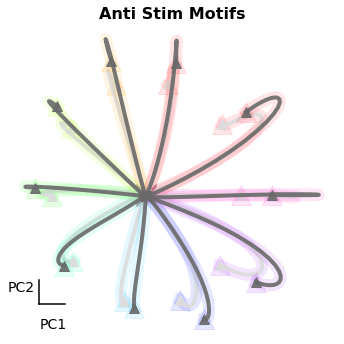

stim1
stim1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
0.158113883008419
Variables being optimi

/Users/lauradriscoll/Documents/code/multitask-nets/stepnet/task.py:120: RuntimeWarning: overflow encountered in multiply
  self.stim_strength = 100*np.empty((len(locs),4))
/Users/lauradriscoll/Documents/code/multitask-nets/stepnet/task.py:120: RuntimeWarning: invalid value encountered in multiply
  self.stim_strength = 100*np.empty((len(locs),4))


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lau

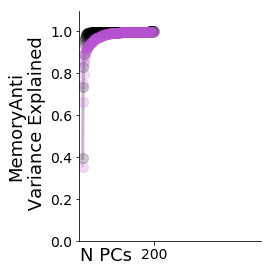

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Var

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/interp_tasks_small_init_stim/fdanti_delayanti/tol_q_e_6.0/fdanti_delayanti_stim1_stim1_x180.0_x180.0_step_18.npz'

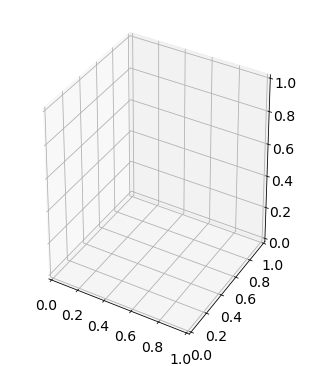

In [17]:
ri_set = [3,5]
epoch_set = ['stim1','stim1']
trial_num = [0,0]

plot_task_overlap(m,ri_set,epoch_set = epoch_set,tit = 'Anti Stim Motifs',ri_axs = 0)

trial_set = gen_trial_set(ri_set)
interp_h_tasks_w_context(ri_set,trial_num,epoch_set,n_interp = 19,ri_axs = 0)
plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Var

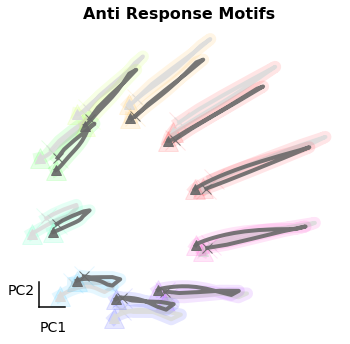

go1
go1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
0.158113883008419
Variables being optimized:

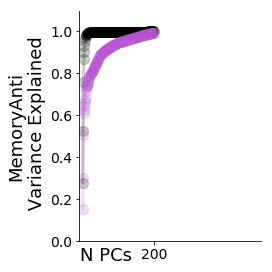

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Var

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt


IOError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/interp_tasks_small_init_stim/fdanti_delayanti/tol_q_e_6.0/fdanti_delayanti_go1_go1_x180.0_x180.0_step_18.npz'

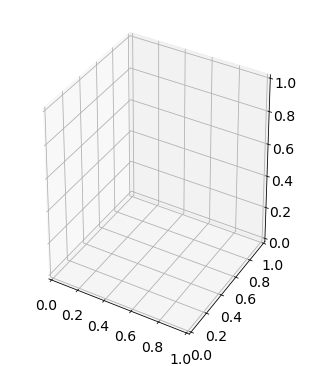

In [18]:
ri_set = [3,5]
epoch_set = ['go1','go1']
trial_num = [0,0]

plot_task_overlap(m,ri_set,epoch_set = epoch_set,tit = 'Anti Response Motifs',ri_axs = 0)

trial_set = gen_trial_set(ri_set)
interp_h_tasks_w_context(ri_set,trial_num,epoch_set,n_interp = 19,ri_axs = 0)
plt.show()

<IPython.core.display.Javascript object>


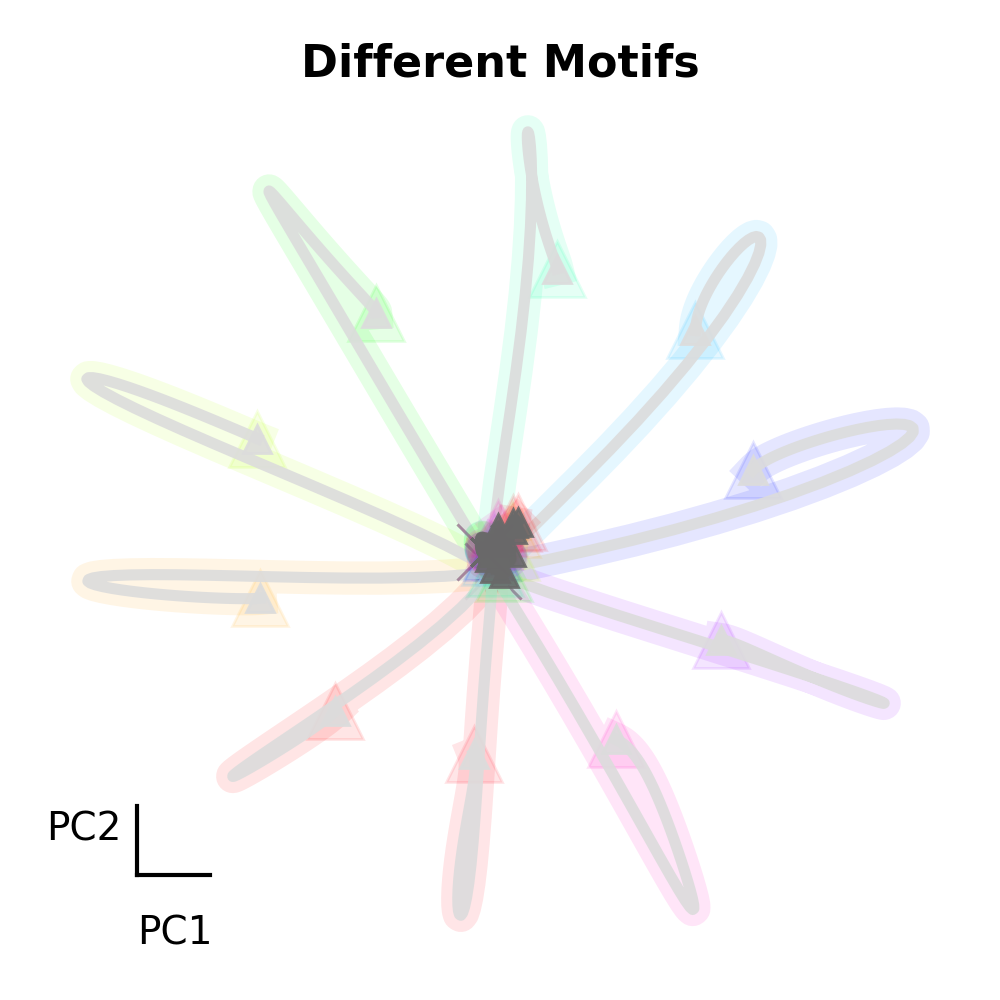

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll

<IPython.core.display.Javascript object>


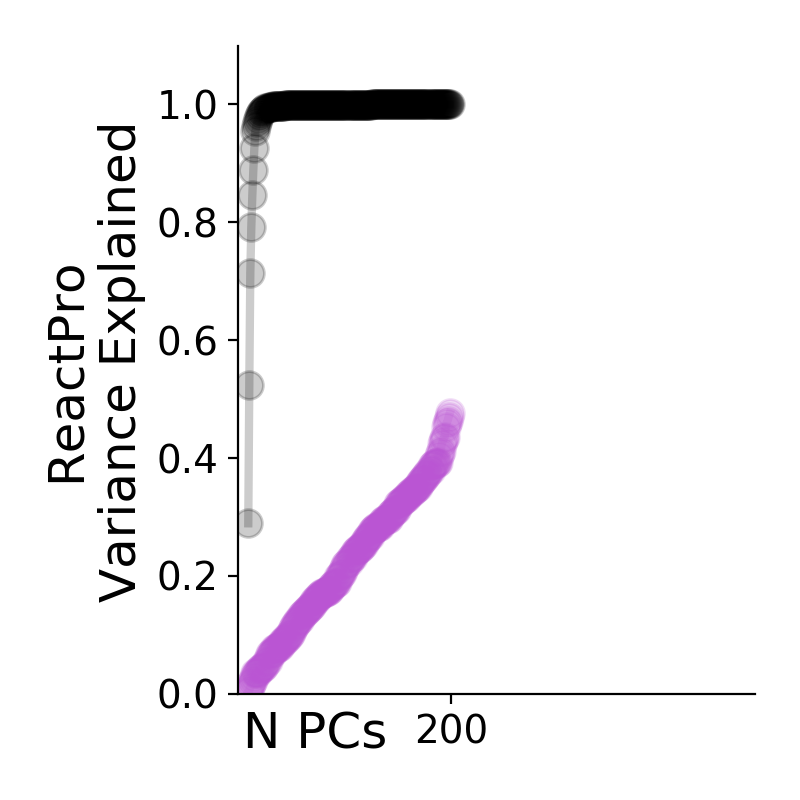

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

<IPython.core.display.Javascript object>


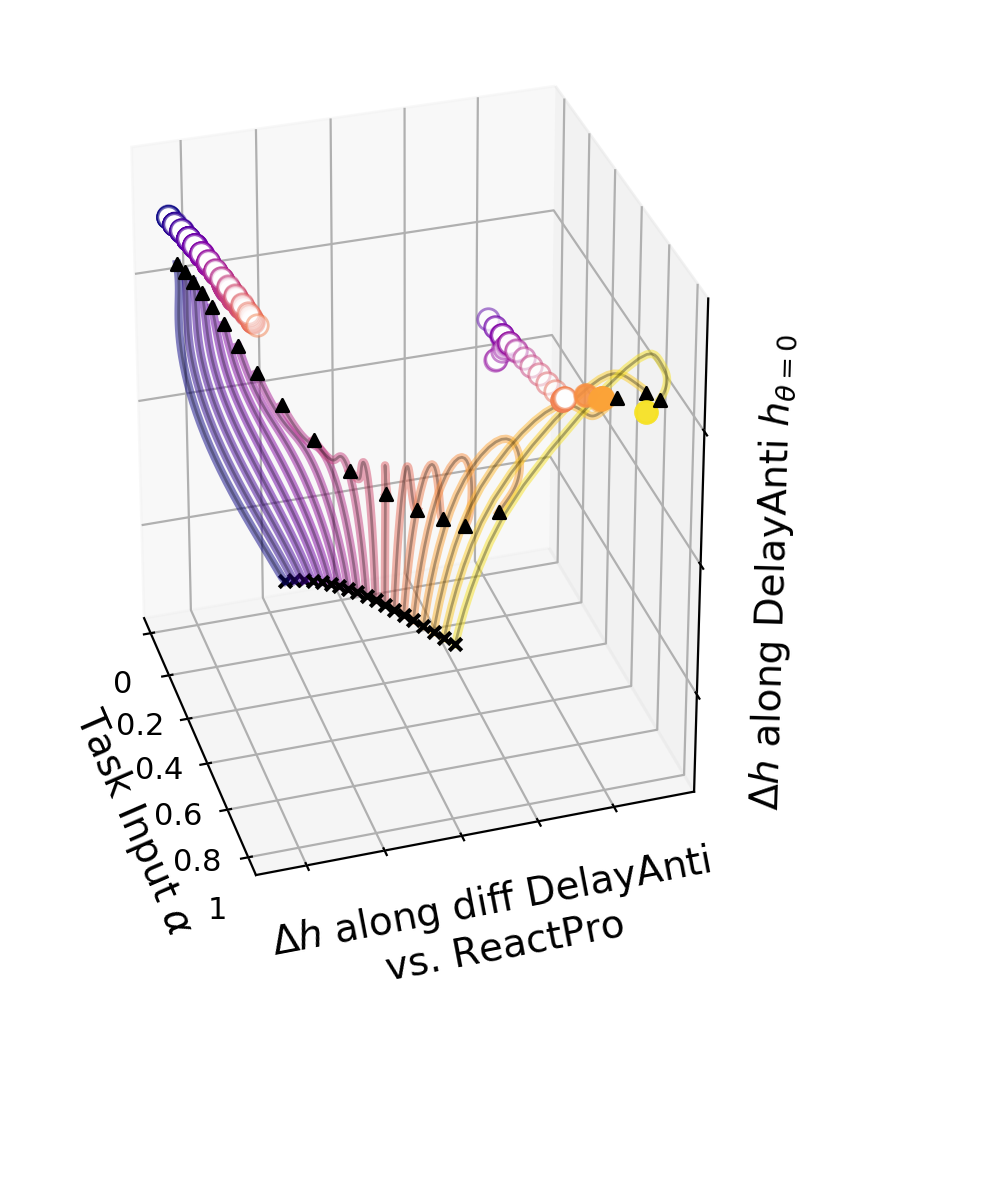

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

In [25]:
ri_set = [3,1]
epoch_set = ['stim1','go1']
trial_num = [0,0]

plot_task_overlap(m,ri_set,epoch_set = epoch_set,tit = 'Different Motifs',ri_axs = 0)

trial_set = gen_trial_set(ri_set)
interp_h_tasks_w_context(ri_set,trial_num,epoch_set,n_interp = 19,ri_axs = 0)
plt.show()

<IPython.core.display.Javascript object>


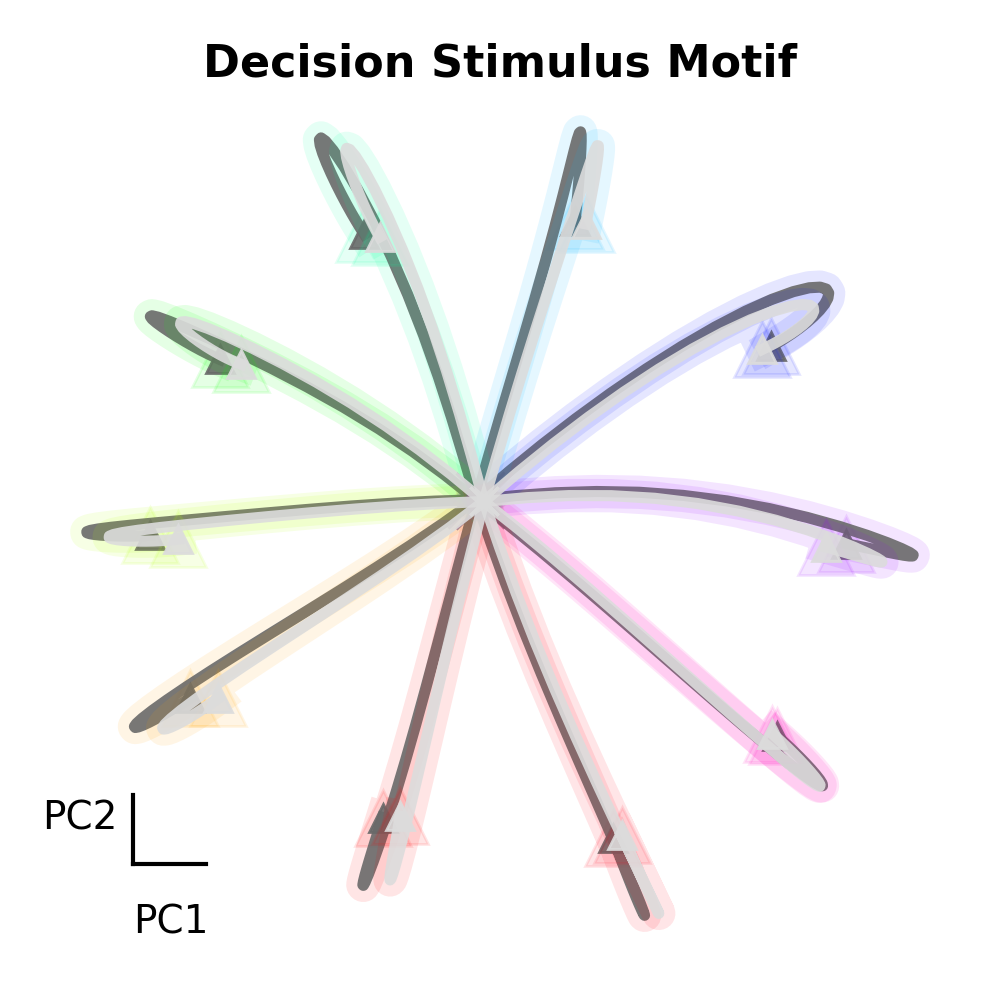

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll

<IPython.core.display.Javascript object>


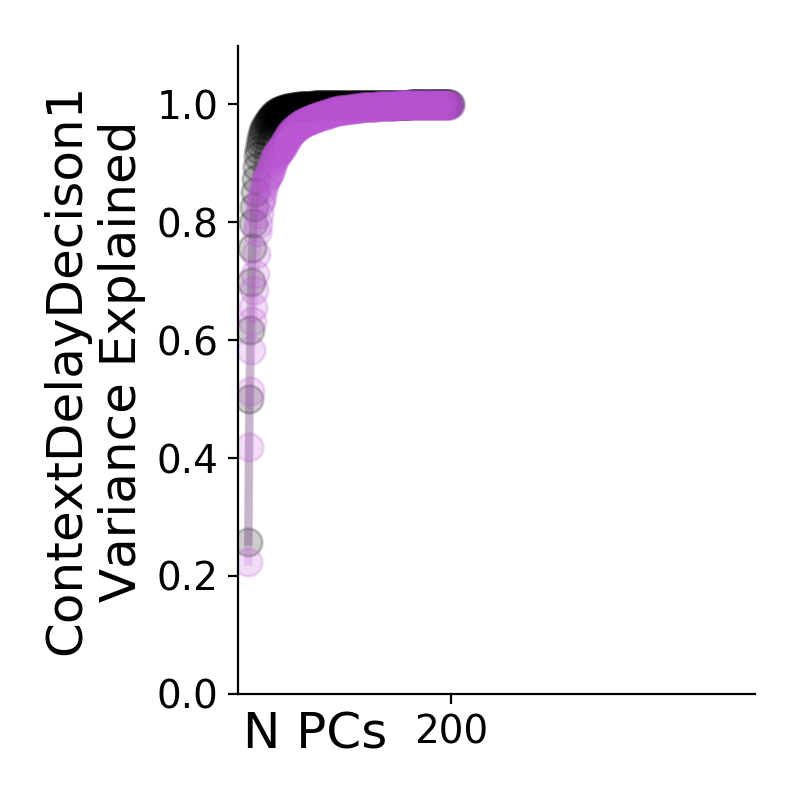

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

<IPython.core.display.Javascript object>


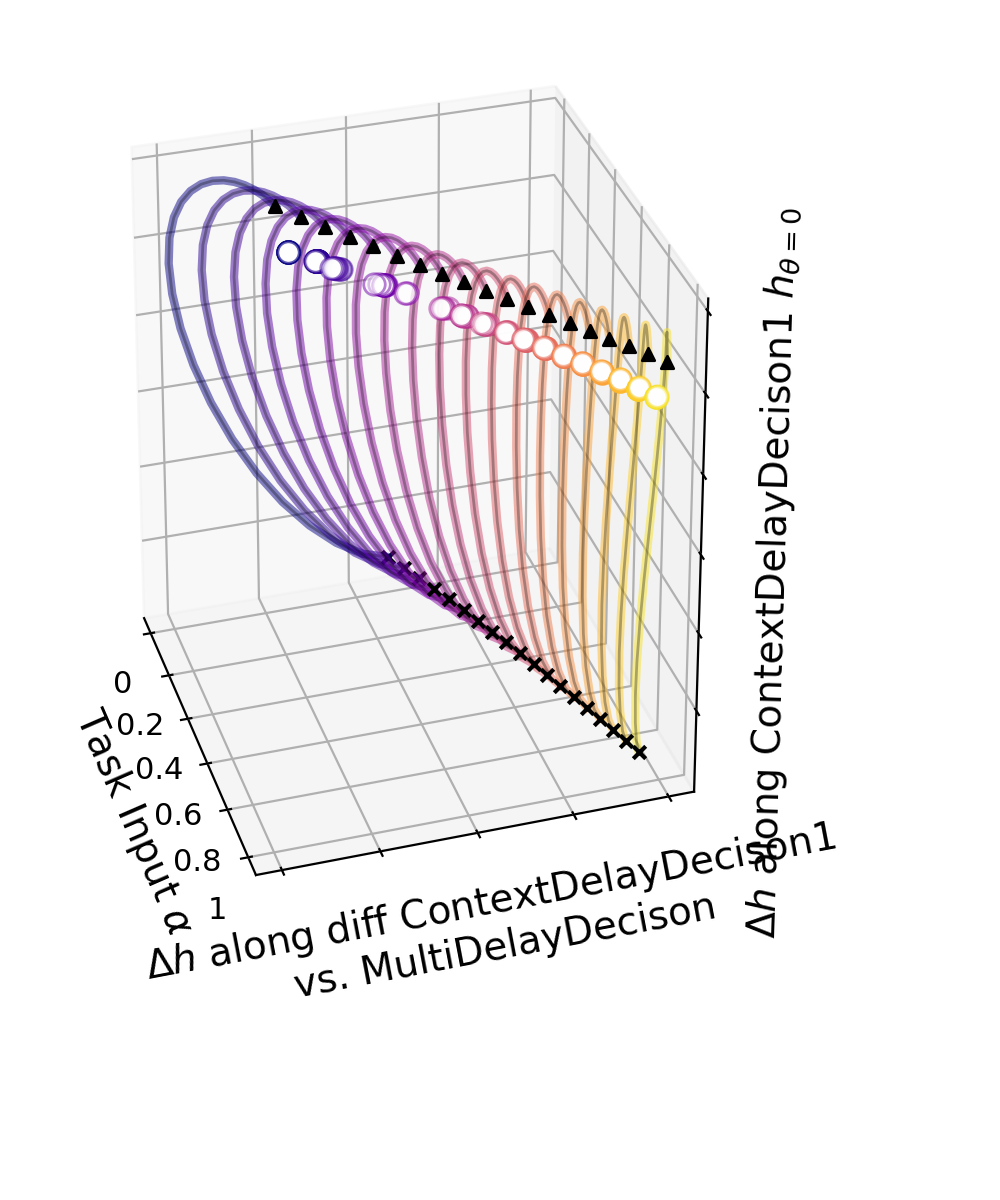

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

In [27]:
ri_set = [13,15]
epoch_set = ['stim1','stim1']
plot_task_overlap(m,ri_set,tit = 'Decision Stimulus Motif')

trial_set = gen_trial_set(ri_set)
interp_h_tasks_w_context(ri_set,trial_num,epoch_set,n_interp = 19)
plt.show()

In [ ]:
# ri_set = [14,15]
# plot_task_overlap(m,ri_set,tit = 'Decision Stimulus Motif')

# trial_set = gen_trial_set(ri_set)
# interp_h_tasks_w_context(ri_set,trial_num,epoch_list,n_interp = 19)
# plt.show()

<IPython.core.display.Javascript object>


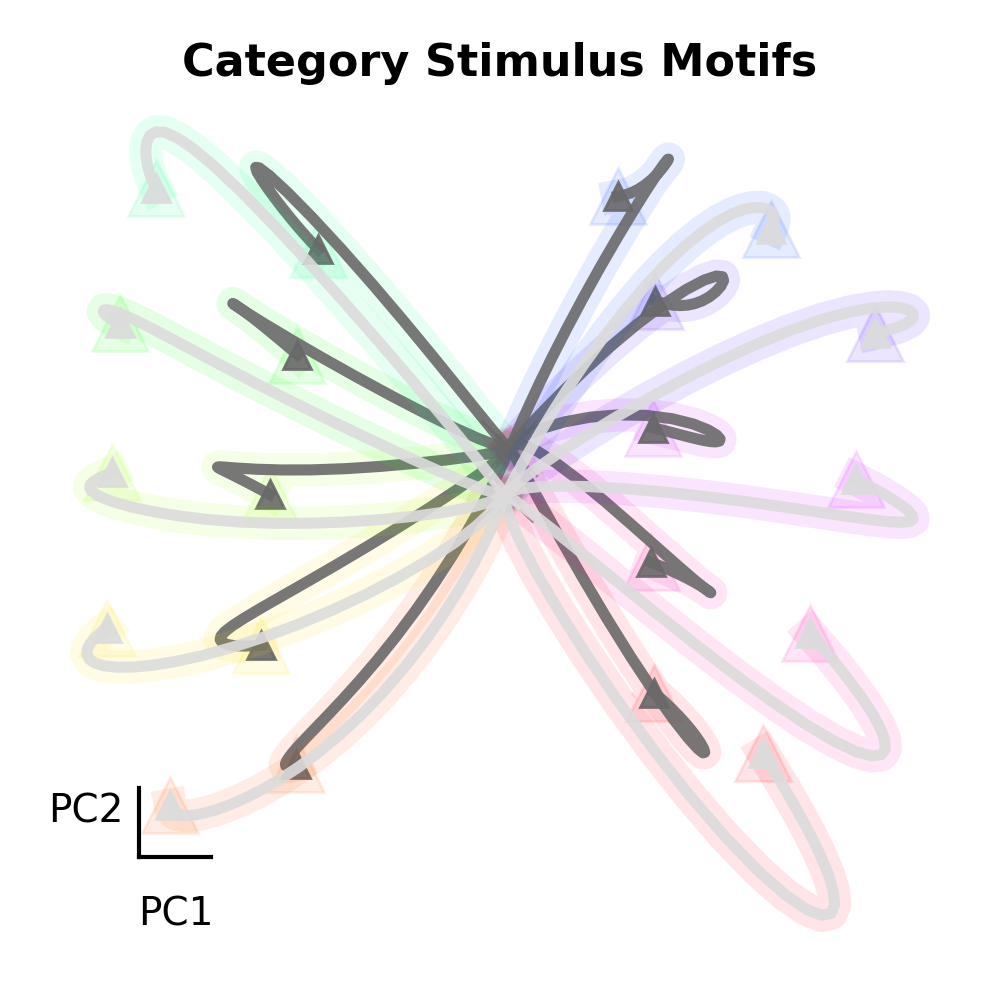

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll

<IPython.core.display.Javascript object>


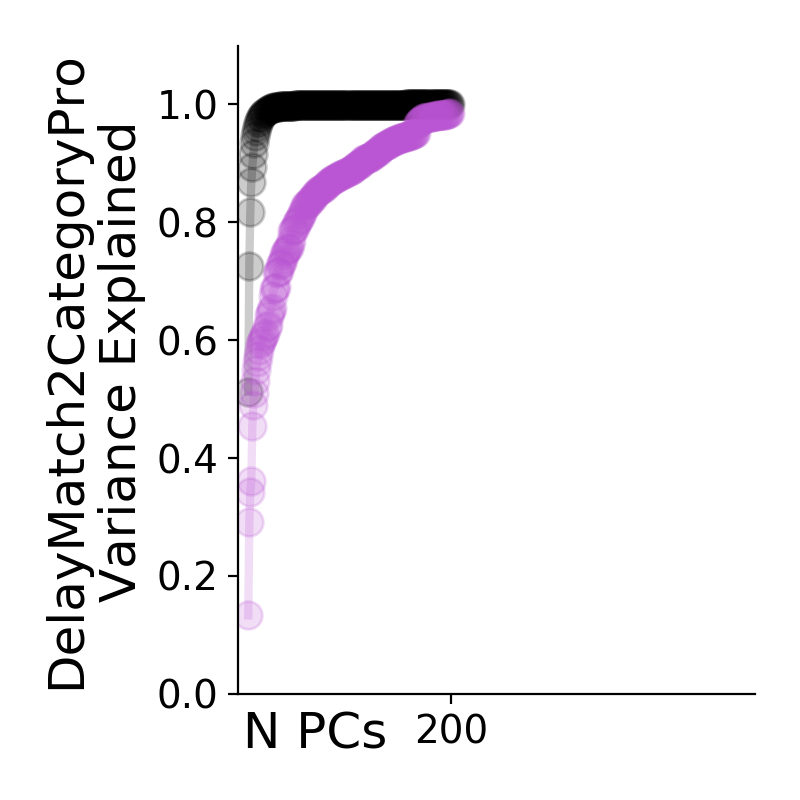

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

<IPython.core.display.Javascript object>


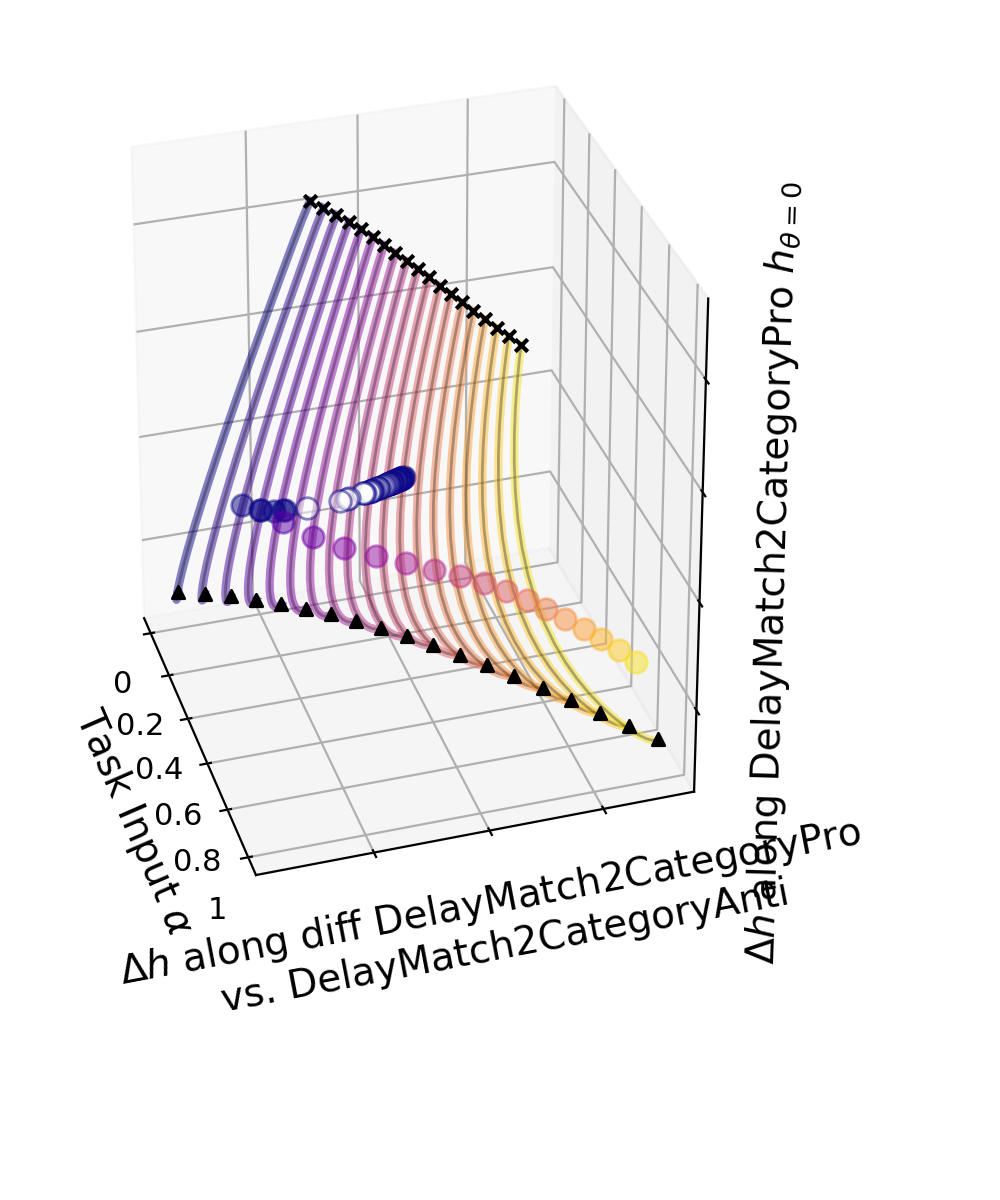

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn

In [29]:
ri_set = [18,19]
epoch_set = ['stim1','stim1']
plot_task_overlap(m,ri_set,tit = 'Category Stimulus Motifs')

trial_set = gen_trial_set(ri_set)
interp_h_tasks_w_context(ri_set,trial_num,epoch_set,n_interp = 19)
plt.show()